In [38]:
from tqdm import tqdm
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pickle as pkl

In [39]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
torch.cuda.is_available()

True

In [41]:
BATCH_SIZE = 32
EPOCHS = 5

In [42]:
otfs_data = scipy.io.loadmat('../data/OTFSData.mat')
otfs_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Rx', 'Tdata', 'chanParamsData', 'tdata', 'xdata'])

In [43]:
Tdata = otfs_data['Tdata'] # transmitted data
Rx = otfs_data['Rx'] # received data
Tdata.shape, Rx.shape

((64, 60, 10000), (10000, 4440))

In [44]:
np.unique(Tdata[:, :, 0][:, 30:])

array([-0.70710678-0.70710678j, -0.70710678+0.70710678j,
        0.70710678-0.70710678j,  0.70710678+0.70710678j])

In [45]:
n = Rx.shape[0]
indices = np.arange(n)
train_indices, test_indices = train_test_split(indices, test_size = 0.2, shuffle = True, random_state = 42)
train_indices.shape, test_indices.shape

((8000,), (2000,))

In [46]:
class SymbolDemodulationDatasetCNNMSE(Dataset):
    def __init__(self, otfs_data, indices, channelEstimationModel = None, ceDiscrete = False):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)

        # information symbols received, and predicted channel parameters
        # Multiply by two for real and complex
        #self.n_features = 2220 * 2 + 16
        #self.n_outputs = 1920 * 2

        # self.X = np.zeros((self.n_samples, 2, 74, 30))
        self.X = np.zeros((self.n_samples, 2, 128, 128))
        # self.Y = np.zeros((self.n_samples, 2, 64, 30))
        self.Y = np.zeros((self.n_samples, 2, 64, 64))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]
            
            rx_info = rx[2220:].reshape(74, 30)
            rx_info_real = np.real(rx_info)
            rx_info_imag = np.imag(rx_info)

            self.X[i, 0, 27:(128-27), 49:(128-49)] = rx_info_real
            self.X[i, 1, 27:(128-27), 49:(128-49)] = rx_info_imag

            # If no model given, just use truth
            # if channelEstimationModel is None:
            #     chanParams = otfs_data['chanParamsData'][idx]
            #     numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
            #     pathDelays = chanParams[0]['pathDelays'][0, 0][0]
            #     pathGains = chanParams[0]['pathGains'][0, 0][0]
            #     pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
            
            #     pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
            #     pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
            #     pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

            #     self.X[i, 4440:] = np.hstack((numPaths, pathDelays, pathGains, pathDopplers))
                
            # In this case, consider outputs as continuous
            tdata = otfs_data['Tdata'][:, :, idx]
            tdata_info = tdata[:, 30:]
            tdata_info_real = np.real(tdata_info)
            tdata_info_imag = np.imag(tdata_info)
            self.Y[i, 0, :, 17:(64-17)] = tdata_info_real
            self.Y[i, 1, :, 17:(64-17)] = tdata_info_imag

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [47]:
class SymbolDemodulationDatasetMSE(Dataset):
    def __init__(self, otfs_data, indices, channelEstimationModel = None, ceDiscrete = False):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)

        # information symbols received, and predicted channel parameters
        # Multiply by two for real and complex
        self.n_features = 2220 * 2 + 16
        self.n_outputs = 1920 * 2

        self.X = np.zeros((self.n_samples, self.n_features))
        self.Y = np.zeros((self.n_samples, self.n_outputs))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]
            
            rx_info = rx[2220:]
            rx_info_real = np.real(rx_info)
            rx_info_imag = np.imag(rx_info)

            self.X[i, :4440] = np.hstack((rx_info_real, rx_info_imag))

            # If no model given, just use truth
            if channelEstimationModel is None:
                chanParams = otfs_data['chanParamsData'][idx]
                numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
                pathDelays = chanParams[0]['pathDelays'][0, 0][0]
                pathGains = chanParams[0]['pathGains'][0, 0][0]
                pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
            
                pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
                pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
                pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

                self.X[i, 4440:] = np.hstack((numPaths, pathDelays, pathGains, pathDopplers))
                
            # In this case, consider outputs as continuous
            tdata = otfs_data['Tdata'][:, :, idx]
            tdata_info = tdata[:, 30:].reshape(-1)
            tdata_info_real = np.real(tdata_info)
            tdata_info_imag = np.imag(tdata_info)
            self.Y[i] = np.hstack((tdata_info_real, tdata_info_imag))

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [48]:
BIT_VALUES = [
    0.7071067811865476+0.7071067811865475j,
    0.7071067811865474-0.7071067811865477j,
    -0.7071067811865475+0.7071067811865476j,
    -0.7071067811865477-0.7071067811865475j
]
class SymbolDemodulationDatasetCE(Dataset):
    def __init__(self, otfs_data, indices, channelEstimationModel = None, ceDiscrete = False):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)

        # information symbols received, and predicted channel parameters
        # Multiply by two for real and complex
        self.n_features = 2220 * 2 + 16
        self.n_outputs = 1920

        self.X = np.zeros((self.n_samples, self.n_features))
        self.Y = np.zeros((self.n_samples, self.n_outputs))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]
            
            rx_info = rx[2220:]
            rx_info_real = np.real(rx_info)
            rx_info_imag = np.imag(rx_info)

            self.X[i, :4440] = np.hstack((rx_info_real, rx_info_imag))

            # If no model given, just use truth
            if channelEstimationModel is None:
                chanParams = otfs_data['chanParamsData'][idx]
                numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
                pathDelays = chanParams[0]['pathDelays'][0, 0][0]
                pathGains = chanParams[0]['pathGains'][0, 0][0]
                pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
            
                pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
                pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
                pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

                self.X[i, 4440:] = np.hstack((numPaths, pathDelays, pathGains, pathDopplers))

            # Encode outputs as series of one hot vectors
            tdata = otfs_data['Tdata'][:, :, idx]
            tdata_info = tdata[:, 30:].reshape(-1)
            self.Y[i, :] = np.array([BIT_VALUES.index(t) for t in tdata_info])
            # self.Y[i, :, 0] = (tdata_info == BIT_VALUES[0]).astype(int)
            # self.Y[i, :, 1] = (tdata_info == BIT_VALUES[1]).astype(int)
            # self.Y[i, :, 2] = (tdata_info == BIT_VALUES[2]).astype(int)
            # self.Y[i, :, 3] = (tdata_info == BIT_VALUES[3]).astype(int)

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y.astype(int))
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [49]:
class SymbolDemodulationNetworkCNNMSE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(SymbolDemodulationNetworkCNNMSE, self).__init__()

        self.conv1 = nn.Conv2d(2, 32, 3, padding = 1, stride = 1).double()
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1, stride = 1).double()
        self.conv3 = nn.Conv2d(32, 32, 3, padding = 1, stride = 2).double()
        self.conv4 = nn.Conv2d(32, 32, 3, padding = 1, stride = 1).double()
        self.conv5 = nn.Conv2d(32, 2, 3, padding = 1, stride = 1).double()

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm2d(32).double()
        self.bn2 = nn.BatchNorm2d(32).double()
        self.bn3 = nn.BatchNorm2d(32).double()
        self.bn4 = nn.BatchNorm2d(32).double()

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout4(F.relu(self.bn4(self.conv4(x))))
        x = self.conv5(x)
        return x

class SymbolDemodulationNetworkMSE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(SymbolDemodulationNetworkMSE, self).__init__()

        self.lin1 = nn.Linear(in_features=4456, out_features=3840).double()
        self.lin2 = nn.Linear(in_features=3840, out_features=3840).double()
        self.lin3 = nn.Linear(in_features=3840, out_features=3840).double()
        self.lin4 = nn.Linear(in_features=3840, out_features=3840).double()
        self.lin5 = nn.Linear(in_features=3840, out_features=3840).double()

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(3840).double()
        self.bn2 = nn.BatchNorm1d(3840).double()
        self.bn3 = nn.BatchNorm1d(3840).double()
        self.bn4 = nn.BatchNorm1d(3840).double()

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.lin1(x))))
        x = self.dropout2(F.relu(self.bn2(self.lin2(x))))
        x = self.dropout3(F.relu(self.bn3(self.lin3(x))))
        x = self.dropout4(F.relu(self.bn4(self.lin4(x))))
        x = self.lin5(x)
        return x

class SymbolDemodulationNetworkCE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(SymbolDemodulationNetworkCE, self).__init__()

        self.lin1 = nn.Linear(in_features=4456, out_features=3840).double()
        self.lin2 = nn.Linear(in_features=3840, out_features=3840).double()
        self.lin3 = nn.Linear(in_features=3840, out_features=3840).double()
        self.lin4 = nn.Linear(in_features=3840, out_features=3840).double()

        lin5_ce_layers_list = []
        for i in range(1920):
            l = nn.Linear(in_features=3840, out_features=4).double()
            lin5_ce_layers_list.append(l)
        self.lin5_ce_layers = nn.ModuleList(lin5_ce_layers_list)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(3840).double()
        self.bn2 = nn.BatchNorm1d(3840).double()
        self.bn3 = nn.BatchNorm1d(3840).double()
        self.bn4 = nn.BatchNorm1d(3840).double()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.dropout1(F.relu(self.bn1(self.lin1(x))))
        x = self.dropout2(F.relu(self.bn2(self.lin2(x))))
        x = self.dropout3(F.relu(self.bn3(self.lin3(x))))
        x = self.dropout4(F.relu(self.bn4(self.lin4(x))))

        # Create tensor to hold all outputs
        y_out = torch.zeros((batch_size, len(self.lin5_ce_layers), 4)).to(x.get_device())
        for i in range(len(self.lin5_ce_layers)):
            y = self.lin5_ce_layers[i](x)
            y_out[:, i, :] = y

        return y_out

In [50]:
def train_model_ce(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam', dropout_rate = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = SymbolDemodulationNetworkCE(dropout_rate)
    model = model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)

    loss_fn_ce = nn.CrossEntropyLoss()

    loss_train_means = []
    loss_test_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_test = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            Y_hat = model(X)

            # Calculate individual CE losses and sum
            loss = torch.tensor(0.0).to(device)
            for i in range(Y.shape[1]):
                Y_i = Y[:, i]
                Y_hat_i = Y_hat[:, i, :]
                l = loss_fn_ce(Y_hat_i, Y_i)
                loss += l
            loss /= Y.shape[1]

            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, Y = batch
                X = X.to(device)
                Y = Y.to(device)
                Y_hat = model(X)
    
                # Calculate individual CE losses and sum
                loss = torch.tensor(0.0).to(device)
                for i in range(Y.shape[1]):
                    Y_i = Y[:, i]
                    Y_hat_i = Y_hat[:, i, :]
                    loss += loss_fn_ce(Y_hat_i, Y_i)
                loss /= Y.shape[1]

                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)

        loss_train_means.append(loss_train_mean)
        loss_test_means.append(loss_test_mean)

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Test Loss =', loss_test_mean)

        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/demod_ce_{}_{}_{}_{}_{}_{}.pth'.format(epoch + 1, lr, optimizer_name, dropout_rate,
                                                                      loss_train_mean, loss_test_mean)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return loss_train_means, loss_test_means

In [51]:
def train_model_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam', dropout_rate = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = SymbolDemodulationNetworkMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)

    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_test_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_test = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            Y_hat = model(X)
            loss = loss_fn_mse(Y_hat, Y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, Y = batch
                X = X.to(device)
                Y = Y.to(device)
                Y_hat = model(X)
                loss = loss_fn_mse(Y_hat, Y)
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)
        
        loss_train_means.append(loss_train_mean)
        loss_test_means.append(loss_test_mean)

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Test Loss =', loss_test_mean)
            
        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/demod_mse_{}_{}_{}_{}_{}_{}.pth'.format(epoch + 1, lr, optimizer_name, dropout_rate,
                                                                       loss_train_mean, loss_test_mean)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return loss_train_means, loss_test_means

In [52]:
def train_model_cnn_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam', dropout_rate = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = SymbolDemodulationNetworkCNNMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)

    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_test_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_test = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            Y_hat = model(X)
            loss = loss_fn_mse(Y_hat, Y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, Y = batch
                X = X.to(device)
                Y = Y.to(device)
                Y_hat = model(X)
                loss = loss_fn_mse(Y_hat, Y)
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)
        
        loss_train_means.append(loss_train_mean)
        loss_test_means.append(loss_test_mean)

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Test Loss =', loss_test_mean)
            
        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'demod_mse_{}_{}_{}_{}_{}_{}.pth'.format(epoch + 1, lr, optimizer_name, dropout_rate,
                                                                       loss_train_mean, loss_test_mean)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return loss_train_means, loss_test_means

In [19]:
f = open('../results_maps/results_map_symboldemodulation_cnn_mse.pkl', 'rb')
results_map_symboldemodulation_cnn_mse = pkl.load(f)
f.close()

min_test_loss = float('inf')
min_test_loss_epoch = None
min_test_loss_params = None
for params, (train_loss_vals, test_loss_vals) in results_map_symboldemodulation_cnn_mse.items():
    m = np.min(test_loss_vals)
    if m < min_test_loss:
        min_test_loss = m
        min_test_loss_epoch = np.argmin(test_loss_vals) + 1
        min_test_loss_params = params
min_test_loss, min_test_loss_epoch, min_test_loss_params

(0.23437504385028987, 63, (0.001, 'rmsprop', 0.4))

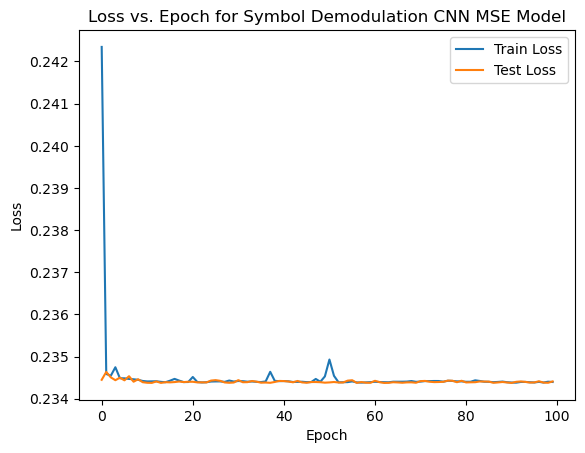

In [20]:
train_loss_vals, test_loss_vals = results_map_symboldemodulation_cnn_mse[min_test_loss_params]

plt.plot(range(len(train_loss_vals)), train_loss_vals, label = 'Train Loss')
plt.plot(range(len(test_loss_vals)), test_loss_vals, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Symbol Demodulation CNN MSE Model')
plt.legend()

In [30]:
dataset_test = SymbolDemodulationDatasetCNNMSE(otfs_data, test_indices)
test_loader = DataLoader(dataset_test, batch_size = BATCH_SIZE)

model = SymbolDemodulationNetworkCNNMSE(min_test_loss_params[2])
model.load_state_dict(torch.load('../model_weights/demod_cnn_mse_63_0.001_rmsprop_0.4_0.2343926538134391_0.23437504385028987.pth'))
model = model.to('cuda')

In [31]:
total_correct = 0
total = 0
v1 = 0.707
v2 = -0.707
f = lambda x: 0 if abs(x - v1) < abs(x - v2) else 1
f_v = np.vectorize(f)
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch
        X = X.to('cuda')
        y_cls = f_v(y.numpy())
        y_hat = model(X).to('cpu')
        y_hat_cls = f_v(y_hat.numpy())
        correct = (y_cls == y_hat_cls).sum()
        total_correct += correct
        total += torch.numel(y) #.shape[0] * y.shape[1]

100%|██████████| 63/63 [00:13<00:00,  4.51it/s]


In [37]:
total_correct / total

0.2343492431640625

In [41]:
m = SymbolDemodulationNetworkCNNMSE()
count_trainable_parameters(m)

29186

In [13]:
lrs = [1e-3, 1e-4, 1e-5]
optimizer_names = ['adam', 'rmsprop', 'adagrad']
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [19]:
# Combine output pkl files into single dict
results_map_ce = {}
g = glob.glob('../results_maps/results_map_symboldemodulation_ce_*')
for t in tqdm(g):
    f = open(t, 'rb')
    r = pkl.load(f)
    f.close()
    for key, val in r.items():
        results_map_ce[key] = [val[1], val[2]]

100%|██████████| 54/54 [03:18<00:00,  3.68s/it]


In [20]:
torch.cuda.empty_cache()

In [114]:
min_test_loss = float('inf')
min_test_loss_epoch = None
min_test_loss_params = None
for params, (train_loss_vals, test_loss_vals) in results_map_ce.items():
    m = np.min(test_loss_vals)
    if m < min_test_loss:
        min_test_loss = m
        min_test_loss_epoch = np.argmin(test_loss_vals) + 1
        min_test_loss_params = params

In [115]:
min_test_loss, min_test_loss_epoch, min_test_loss_params

(np.float64(1.3865601410941473), np.int64(65), (1e-05, 'adagrad', 0.5))

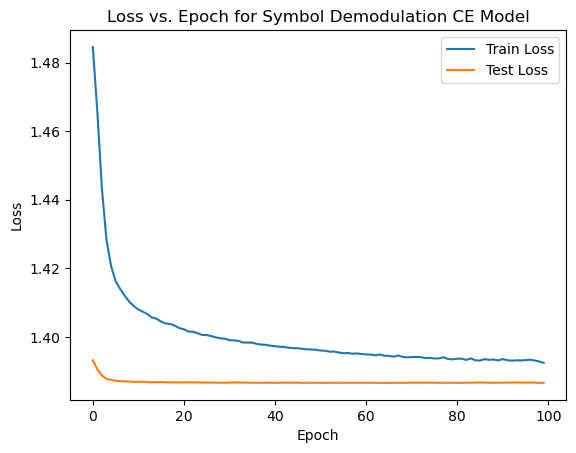

In [116]:
train_loss_vals, test_loss_vals = results_map_ce[min_test_loss_params]

plt.plot(range(len(train_loss_vals)), train_loss_vals, label = 'Train Loss')
plt.plot(range(len(test_loss_vals)), test_loss_vals, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Symbol Demodulation CE Model')
plt.legend()

In [117]:
dataset_test = SymbolDemodulationDatasetCE(otfs_data, test_indices)
test_loader = DataLoader(dataset_test, batch_size = BATCH_SIZE)

In [118]:
path_search = '../model_weights_old/demod_ce_{}_{}_{}_{}*'.format(min_test_loss_epoch, *min_test_loss_params)
path = glob.glob(path_search)[0]
path

'../model_weights_old/demod_ce_65_1e-05_adagrad_0.5_1.3944680027961731_1.3865601410941473.pth'

In [119]:
model = SymbolDemodulationNetworkCE(min_test_loss_params[2])
model.load_state_dict(torch.load(path))
model.to('cuda')

SymbolDemodulationNetworkCE(
  (lin1): Linear(in_features=4456, out_features=3840, bias=True)
  (lin2): Linear(in_features=3840, out_features=3840, bias=True)
  (lin3): Linear(in_features=3840, out_features=3840, bias=True)
  (lin4): Linear(in_features=3840, out_features=3840, bias=True)
  (lin5_ce_layers): ModuleList(
    (0-1919): 1920 x Linear(in_features=3840, out_features=4, bias=True)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)

In [120]:
count_trainable_parameters(model)

90892800

In [62]:
total_correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch
        X = X.to('cuda')
        y_hat = model(X).to('cpu')
        y = y.numpy()
        y_hat = np.argmax(y_hat, axis = 2).numpy()
        correct = (y == y_hat).sum()
        total_correct += correct
        total += y.shape[0] * y.shape[1]

100%|██████████| 63/63 [00:03<00:00, 17.73it/s]


In [63]:
total_correct / total

np.float64(0.2501950520833333)

In [53]:
# Combine output pkl files into single dict
results_map_mse = {}
g = glob.glob('../results_maps/results_map_symboldemodulation_mse_*')
for t in tqdm(g):
    f = open(t, 'rb')
    r = pkl.load(f)
    f.close()
    for key, val in r.items():
        results_map_mse[key] = val

100%|██████████| 54/54 [00:00<00:00, 503.17it/s]


In [54]:
min_test_loss = float('inf')
min_test_loss_epoch = None
min_test_loss_params = None
for params, (train_loss_vals, test_loss_vals) in results_map_mse.items():
    m = np.min(test_loss_vals)
    if m < min_test_loss:
        min_test_loss = m
        min_test_loss_epoch = np.argmin(test_loss_vals) + 1
        min_test_loss_params = params

In [55]:
min_test_loss, min_test_loss_epoch, min_test_loss_params

(0.5001671456231785, 98, (1e-05, 'adagrad', 0.5))

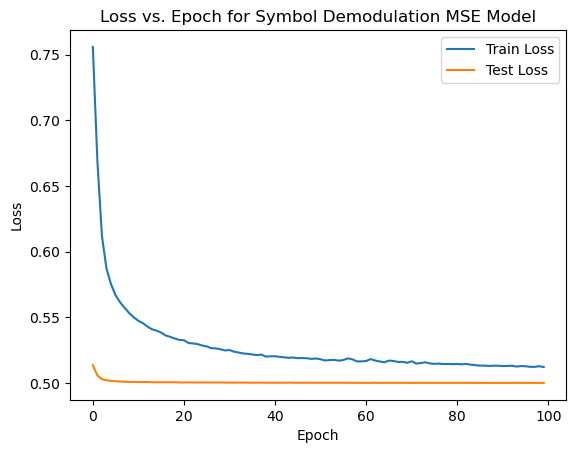

In [56]:
train_loss_vals, test_loss_vals = results_map_mse[min_test_loss_params]

plt.plot(range(len(train_loss_vals)), train_loss_vals, label = 'Train Loss')
plt.plot(range(len(test_loss_vals)), test_loss_vals, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Symbol Demodulation MSE Model')
plt.legend()

In [57]:
dataset_test = SymbolDemodulationDatasetMSE(otfs_data, test_indices)
test_loader = DataLoader(dataset_test, batch_size = BATCH_SIZE)

In [58]:
path_search = '../model_weights/demod_mse_{}_{}_{}*'.format(*min_test_loss_params)
path = glob.glob(path_search)[0]
path

'../model_weights/demod_mse_1e-05_adagrad_0.5.pth'

In [59]:
model = SymbolDemodulationNetworkMSE(min_test_loss_params[2])
model.load_state_dict(torch.load(path))
model.to('cuda')

SymbolDemodulationNetworkMSE(
  (lin1): Linear(in_features=4456, out_features=3840, bias=True)
  (lin2): Linear(in_features=3840, out_features=3840, bias=True)
  (lin3): Linear(in_features=3840, out_features=3840, bias=True)
  (lin4): Linear(in_features=3840, out_features=3840, bias=True)
  (lin5): Linear(in_features=3840, out_features=3840, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [60]:
total_correct = 0
total = 0
v1 = 0.707
v2 = -0.707
f = lambda x: 0 if abs(x - v1) < abs(x - v2) else 1
f_v = np.vectorize(f)
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch
        X = X.to('cuda')
        y_cls = f_v(y.numpy())
        y_hat = model(X).to('cpu')
        y_hat_cls = f_v(y_hat.numpy())
        correct = (y_cls == y_hat_cls).sum()
        total_correct += correct
        total += y.shape[0] * y.shape[1]

100%|██████████| 63/63 [00:04<00:00, 14.54it/s]


In [62]:
total_correct / total / 2

0.25007734375

In [14]:
try:
    f = open('results_map_symboldemodulation_ce.pkl', 'rb')
    results_map_symboldemodulation_ce = pkl.load(f)
    f.close()
except:
    results_map_symboldemodulation_ce = {}

In [15]:
for lr in lrs:
    for optimizer_name in optimizer_names:
        for dropout_rate in dropout_rates:
            dataset_train = SymbolDemodulationDatasetCE(otfs_data, train_indices)
            train_loader = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle=True)
            
            dataset_test = SymbolDemodulationDatasetCE(otfs_data, test_indices)
            test_loader = DataLoader(dataset_test, batch_size = BATCH_SIZE)

            k = (lr, optimizer_name, dropout_rate)
            print(k)
            if k in results_map_symboldemodulation_ce:
                print(k, 'already trained, skipping')
                continue
            
            results_map_symboldemodulation_ce[k] = train_model_ce(train_loader, test_loader, epochs = EPOCHS,
                           lr = lr, optimizer_name = optimizer_name, dropout_rate = dropout_rate, verbose = True)

(0.001, 'adam', 0.0)
Device = cuda
Epoch 1


100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


Train Loss = 6.848520669460297
Test Loss = 2.357284458856734
New min test loss = 2.357284458856734
--------------------------------------------------------------------------------
Epoch 2


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


Train Loss = 1.6027475442886352
Test Loss = 1.4049537484608
New min test loss = 1.4049537484608
--------------------------------------------------------------------------------
Epoch 3


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


Train Loss = 1.3951317620277406
Test Loss = 1.4340459600327506
--------------------------------------------------------------------------------
Epoch 4


100%|██████████| 63/63 [00:18<00:00,  3.33it/s]


Train Loss = 1.5004615898132325
Test Loss = 25.828202158685716
--------------------------------------------------------------------------------
Epoch 5


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]

Train Loss = 1.6362642412185668
Test Loss = 1.4050033849383157
--------------------------------------------------------------------------------


In [16]:
f = open('results_map_symboldemodulation_ce.pkl', 'wb')
pkl.dump(results_map_symboldemodulation_ce, f)
f.close()

In [17]:
try:
    f = open('results_map_symboldemodulation_mse.pkl', 'rb')
    results_map_symboldemodulation_mse = pkl.load(f)
    f.close()
except:
    results_map_symboldemodulation_mse = {}

In [22]:
for lr in lrs:
    for optimizer_name in optimizer_names:
        for dropout_rate in dropout_rates:
            dataset_train = SymbolDemodulationDatasetMSE(otfs_data, train_indices)
            train_loader = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle=True)
            
            dataset_test = SymbolDemodulationDatasetMSE(otfs_data, test_indices)
            test_loader = DataLoader(dataset_test, batch_size = BATCH_SIZE)

            k = (lr, optimizer_name, dropout_rate)
            print(k)
            if k in results_map_symboldemodulation_mse:
                print(k, 'already trained, skipping')
                continue
            
            results_map_symboldemodulation_mse[k] = train_model_mse(train_loader, test_loader, epochs = EPOCHS,
                           lr = lr, optimizer_name = optimizer_name, dropout_rate = dropout_rate, verbose = True)

(0.001, 'adam', 0.0)
Device = cuda
Epoch 1


100%|██████████| 63/63 [00:01<00:00, 42.61it/s]


Train Loss = 52.383911469164495
Test Loss = 21.623634259004948
New min test loss = 21.623634259004948
--------------------------------------------------------------------------------
Epoch 2


100%|██████████| 63/63 [00:01<00:00, 42.59it/s]


Train Loss = 4.833529704185012
Test Loss = 0.6600447675172121
New min test loss = 0.6600447675172121
--------------------------------------------------------------------------------
Epoch 3


100%|██████████| 63/63 [00:01<00:00, 42.33it/s]


Train Loss = 0.7387526910745916
Test Loss = 2.373903325449596
--------------------------------------------------------------------------------
Epoch 4


100%|██████████| 63/63 [00:01<00:00, 42.32it/s]


Train Loss = 1.7433477259200796
Test Loss = 26346.697069991173
--------------------------------------------------------------------------------
Epoch 5


100%|██████████| 63/63 [00:01<00:00, 42.35it/s]

Train Loss = 4.574451816107044
Test Loss = 7.57591884357297
--------------------------------------------------------------------------------


In [20]:
f = open('results_map_symboldemodulation_mse.pkl', 'wb')
pkl.dump(results_map_symboldemodulation_mse, f)
f.close()